## Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array

import matplotlib.pyplot as plt

In [2]:
# Set the random_seed to make sure the results are reproducible
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
batch_size = 32
img_size = (224, 224)

## Load Dataset

In [ ]:
# Unzip the dataset.zip
import zipfile
import os


def extract_dataset(zip_path, extract_path):
    if not os.path.exists(zip_path):
        print(f"The file {zip_path} does not exist.")
    else:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:  
            zip_ref.extractall(extract_path)
            print(f"Files extracted to {extract_path}")
            
extract_dataset('cats.zip', './dataset/training_set')
extract_dataset('dogs.zip', './dataset/training_set')
extract_dataset('test_set.zip', './dataset')

In [3]:
# On kaggle
train_data_dir = "/kaggle/input/cats-and-dogs/dataset/training_set"
test_data_dir = "/kaggle/input/cats-and-dogs/dataset/test_set"

# Local
# train_data_dir = "./dataset/training_set"
# test_data_dir = "./dataset/test_set"

In [4]:
train_dataset = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="training",
    seed=random_seed,
    image_size=img_size,
    batch_size=batch_size
)

val_dataset = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=random_seed,
    image_size=img_size,
    batch_size=batch_size
)

Found 8000 files belonging to 2 classes.
Using 6400 files for training.
Found 8000 files belonging to 2 classes.
Using 1600 files for validation.


In [5]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

## Load Pre-trained Model

In [6]:
# base_model = tf.keras.applications.ResNet50(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet'
# )

base_model = tf.keras.applications.EfficientNetB4(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # freeze the layers in pre-trained model

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [7]:
base_model.summary()

Model: "efficientnetb4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      1,152 │ block1a_se_excit

 Total params: 17,673,823 (67.42 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,673,823 (67.42 MB)

## Train

In [8]:
optimizer = Adam(learning_rate=1e-4, weight_decay=1e-4)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [9]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10


2024-12-10 18:28:03.309662: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/efficientnetb4_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 160ms/step - accuracy: 0.9362 - loss: 0.2784 - val_accuracy: 0.9925 - val_loss: 0.0388
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.9839 - loss: 0.0573 - val_accuracy: 0.9950 - val_loss: 0.0243
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - accuracy: 0.9886 - loss: 0.0397 - val_accuracy: 0.9950 - val_loss: 0.0195
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.9896 - loss: 0.0320 - val_accuracy: 0.9950 - val_loss: 0.0182
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.9907 - loss: 0.0294 - val_accuracy: 0.9950 - val_loss: 0.0169
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.9917 - loss: 0.0269 - val_accuracy: 0.9950 - val_loss: 0.0166
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - accuracy: 0.9915 - loss: 0.0254 - val_accuracy: 0.9937 - val_loss: 0.0165
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.9882 - loss: 0.0291 - val

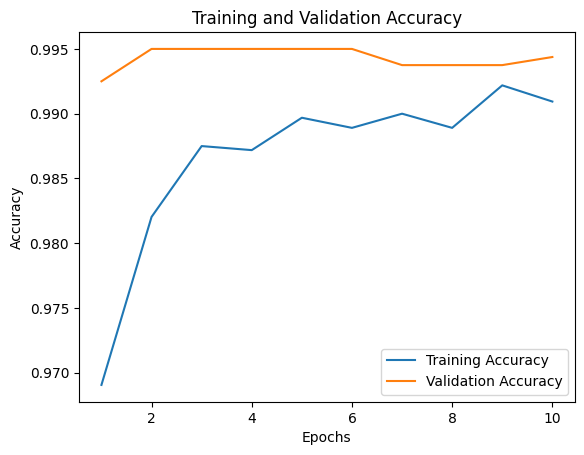

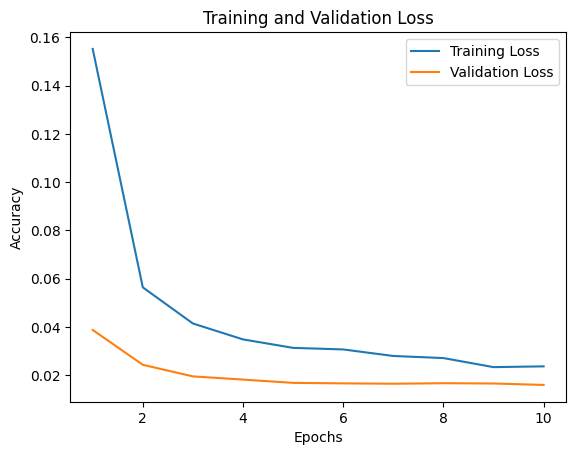

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [11]:
batch_size = 32
img_size = (224, 224)

test_dataset = image_dataset_from_directory(
    test_data_dir,
    image_size=img_size,
    batch_size=batch_size
)

Found 2000 files belonging to 2 classes.


In [12]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.9917 - loss: 0.0305
Test Accuracy: 0.9920
Test Loss: 0.0233


## Error Analysis

In [13]:
test_dataset = image_dataset_from_directory(
    test_data_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 2000 files belonging to 2 classes.


In [14]:
# True labels
true_labels = np.concatenate([labels.numpy() for _, labels in test_dataset])

# Predict labels
predictions = model.predict(test_dataset)
predicted_labels = (predictions > 0.5).astype(int).flatten()

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step


In [15]:
# Get the idxs of misclassified samples
incorrect_indices = np.where(predicted_labels != true_labels)[0]
print(f"numbers of misclassified samples: {len(incorrect_indices)}")

numbers of misclassified samples: 16


/kaggle/input/cats-and-dogs/dataset/test_set/cats/cat.4008.jpg


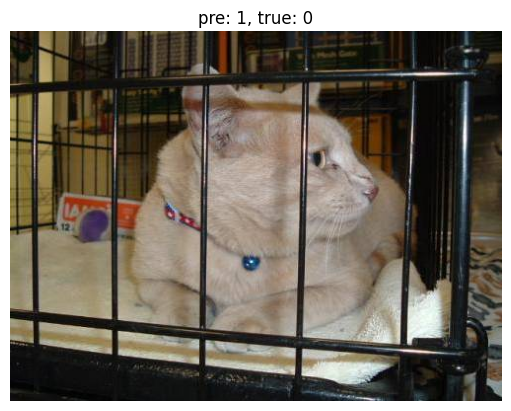

/kaggle/input/cats-and-dogs/dataset/test_set/cats/cat.4047.jpg


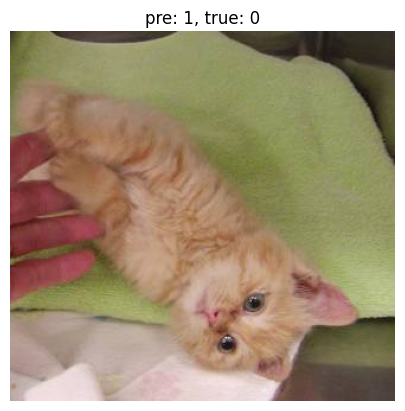

/kaggle/input/cats-and-dogs/dataset/test_set/cats/cat.4085.jpg


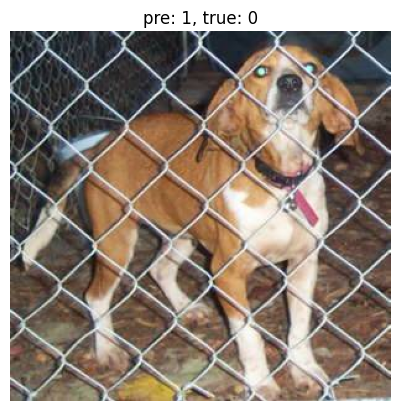

/kaggle/input/cats-and-dogs/dataset/test_set/cats/cat.4190.jpg


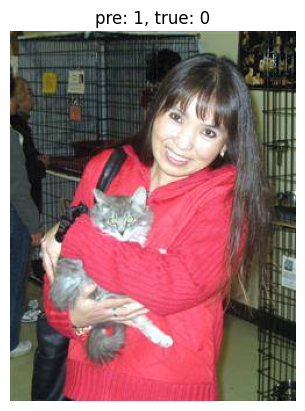

/kaggle/input/cats-and-dogs/dataset/test_set/cats/cat.4207.jpg


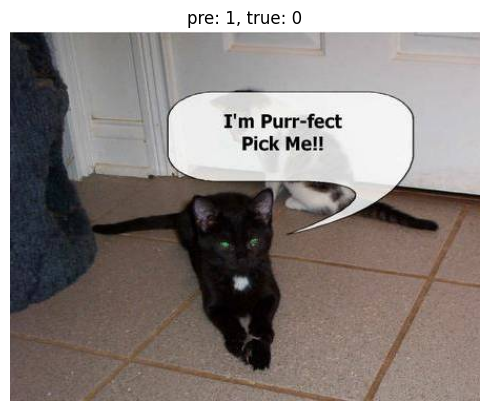

/kaggle/input/cats-and-dogs/dataset/test_set/cats/cat.4211.jpg


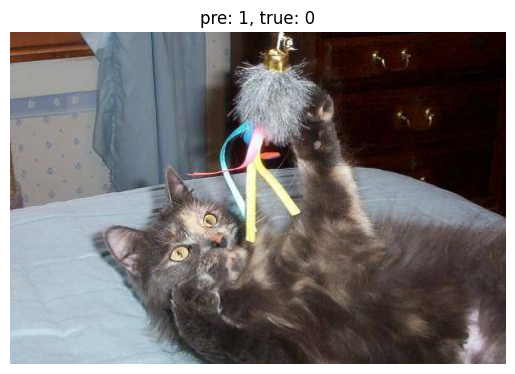

/kaggle/input/cats-and-dogs/dataset/test_set/cats/cat.4308.jpg


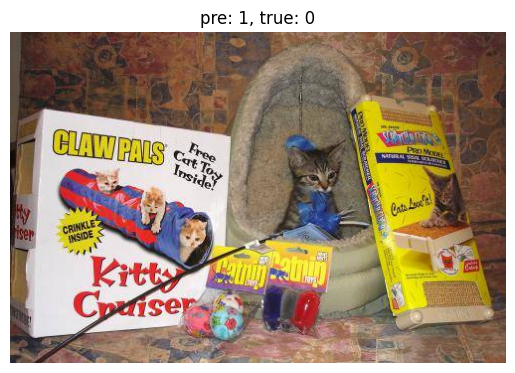

/kaggle/input/cats-and-dogs/dataset/test_set/cats/cat.4360.jpg


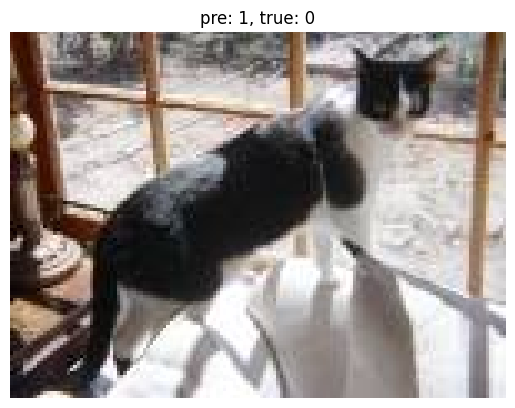

/kaggle/input/cats-and-dogs/dataset/test_set/cats/cat.4622.jpg


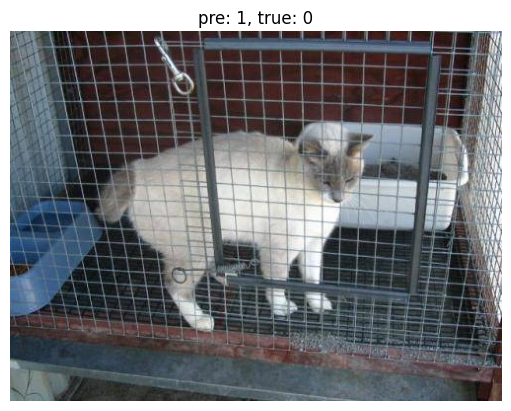

/kaggle/input/cats-and-dogs/dataset/test_set/cats/cat.4688.jpg


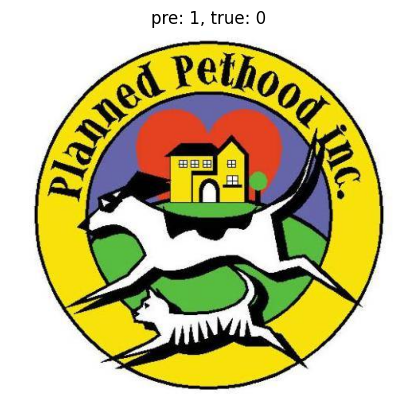

/kaggle/input/cats-and-dogs/dataset/test_set/cats/cat.4771.jpg


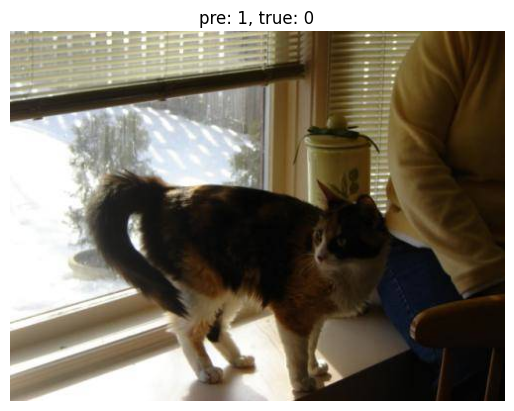

/kaggle/input/cats-and-dogs/dataset/test_set/cats/cat.4874.jpg


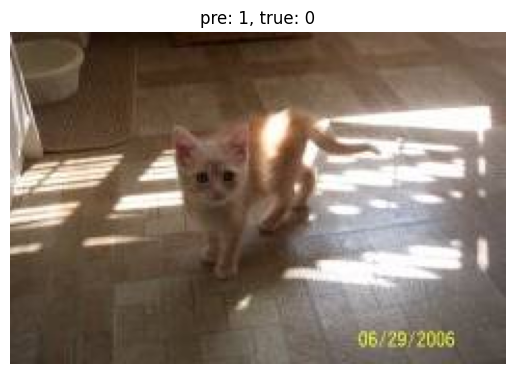

/kaggle/input/cats-and-dogs/dataset/test_set/cats/cat.4986.jpg


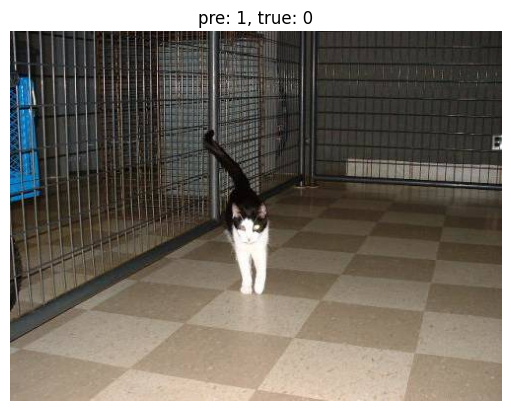

/kaggle/input/cats-and-dogs/dataset/test_set/dogs/dog.4098.jpg


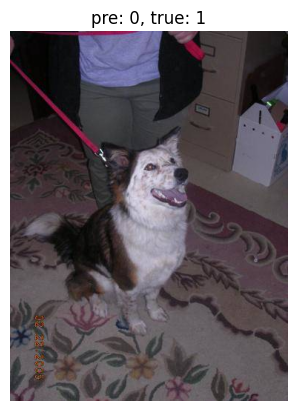

/kaggle/input/cats-and-dogs/dataset/test_set/dogs/dog.4334.jpg


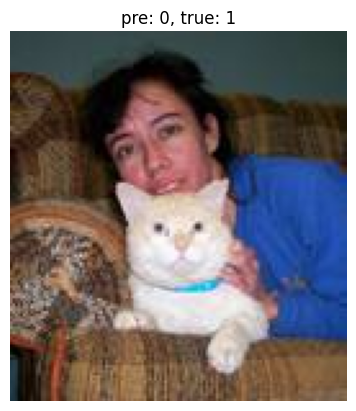

/kaggle/input/cats-and-dogs/dataset/test_set/dogs/dog.4604.jpg


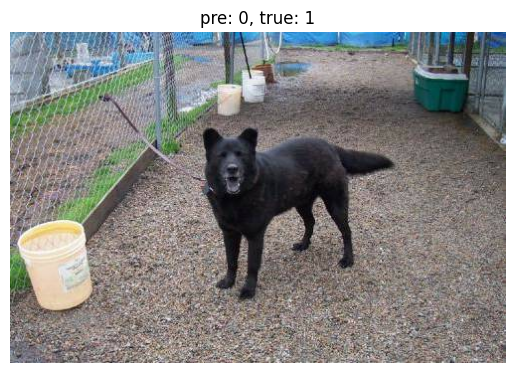

In [16]:
# shows the misclassified imgs
for i, idx in enumerate(incorrect_indices[:]):
    img = plt.imread(test_dataset.file_paths[idx])  # load the imgb
    print(test_dataset.file_paths[idx])
    plt.figure()
    plt.imshow(img)
    plt.title(f"pre: {predicted_labels[idx]}, true: {true_labels[idx]}")
    plt.axis('off')
    plt.show()

## Predict

In [17]:
# Making a single prediction

# On kaggle
image_path_1 = "/kaggle/input/cats-and-dogs/dataset/single_prediction/cat_or_dog_1.jpg"
image_path_2 = "/kaggle/input/cats-and-dogs/dataset/single_prediction/cat_or_dog_2.jpg"

# Local
# image_path_1 = "./dataset/single_prediction/cat_or_dog_1.jpg"
# image_path_2 = "./dataset/single_prediction/cat_or_dog_2.jpg"

class_names = ["cat", "dog"]

In [18]:
def make_single_pred(img_path):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # Predict
    prediction = model.predict(img_array)
    predicted_label = 1 if prediction[0] > 0.5 else 0
    print(f"prediction: {class_names[predicted_label]}")
    plt.imshow(img)
    plt.title(f"pred: {class_names[predicted_label]}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
prediction: dog


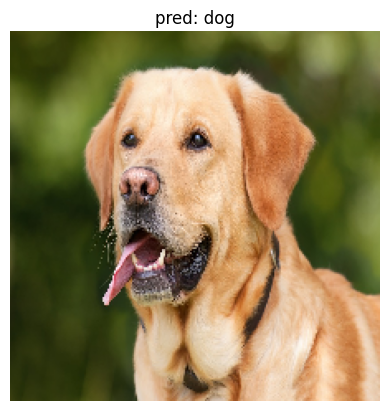

In [19]:
make_single_pred(image_path_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
prediction: cat


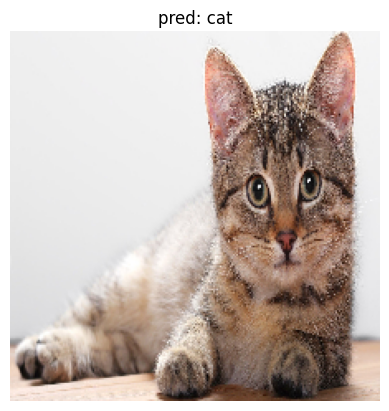

In [20]:
make_single_pred(image_path_2)

### github
https://github.com/Clyde9527/cats-dogs-classification

### Medium
https://medium.com/@clyde94guo/this-is-a-test-cc1b1ab5be96

### Kaggle
I finished this project mainly on kaggl because there are free P100 GPUs for trainning.
There are 7 versions of my work. The first one is a basic pipeline and the model performed bad.
Based on that pipeline I imporved my model step-by-step by appling pretrained models, data augmentation, lr_decay etc. If you are interested check the link below:   

https://www.kaggle.com/code/clyde7470/baseline?scriptVersionId=212361300